In [1]:
from os.path import join
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from growth.sweep.sweep import Sweep
from clones.visualization.settings import *
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from clones.annotation.spatial import WeightedGraph
from clones.annotation.spatial.sampling import CommunitySampler, NeighborSampler
from clones.annotation.annotation import Annotation

In [3]:
def score(x, y):
    """ Returns fraction of labels that are the same. """
    return (x==y).sum()/x.size

In [4]:
# from clones.data.experiments import Experiment

# stack_id = 4
# layer_id = 0

# # load experiment
# experiment = Experiment('../../../data/drosophila/')

# # load image stack
# stack = experiment.load_stack(experiment.stack_ids[stack_id], full=True)
# layer = stack[layer_id]

# Generate synthetic data

Load simulated bleedthrough control experiment and generate synthetic fluorescence data. Synthetic images contain three color channels:
   - BLUE: Nuclear stain
   - RED: Clonal marker
   - GREEN: Control reporter

In [4]:
ambiguity = 0.3

sweep = Sweep.load('../../../data/synthetic/sweeps/Sweep_181201_191516/')
simulation = sweep[415]

measurement_kwargs = dict(measurement_noise=0.)
microscopy_kwargs = dict(bg_level=0.2, bg_noise=0.3)

microscopy = simulation.generate_microscopy(ambiguity=ambiguity, rho=0.0, bleedthrough=0.5, 
                measurement_kwargs=measurement_kwargs, microscopy_kwargs=microscopy_kwargs)

data = microscopy.data

In [5]:
attr = 'clonal_marker'
graph = WeightedGraph(data, attr)

# ground truth
ground_truth = graph.df.true_dosage.values

def plot(ax, labels, label):
    ax.scatter(graph.df.centroid_x, graph.df.centroid_y, c=labels, s=2)
    ax.set_title('{:s}\n{:0.2%}'.format(label, score(ground_truth, labels)))
    ax.axis('off')
    ax.set_aspect(1)

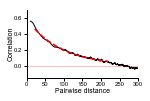

In [11]:
correlation = graph.get_correlations('clonal_marker')
#correlation.histogram_distances(bins=100)
#correlation.histogram_fluctuations(bins=100)
correlation.visualize(window_size=500, max_distance=300)

from clones.annotation.spatial.correlation import CharacteristicLength
char = CharacteristicLength(correlation)
char.plot_fit(ax=plt.gca(), color='r', linestyle='--')

In [108]:
xdecay

array([ 26.13996678,  26.21553441,  26.29110204, ..., 264.50787281,
       264.53276849, 264.55766267])

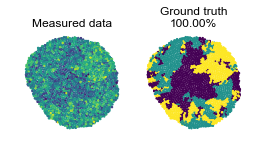

In [6]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(4,2))

ax0.scatter(graph.df.centroid_x, graph.df.centroid_y, c=np.log(graph.df.clonal_marker), s=2)
ax0.set_title('Measured data')
ax0.axis('off')
ax0.set_aspect(1)

plot(ax1, ground_truth, 'Ground truth')

### Train classifier

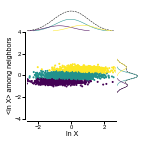

In [23]:
n_depth = 3
c_depth = 1

kw = dict(depth=n_depth)
annotator = Annotation('clonal_marker', sampler_type='neighbors', sampler_kwargs=kw, max_num_components=3)

#depth = 3
#kw = dict(twolevel=False, depth=c_depth)
#annotator = Annotation('clonal_marker', sampler_type='community', sampler_kwargs=kw, min_num_components=3, max_num_components=3)

selector = annotator.train(graph)
_ = annotator.classifier.plot_bivariate_data(s=1)

### Assign labels

In [24]:
marginal_labels = annotator.annotate(graph, sampler_type=None, threshold=1.)
neighborhood_labels = annotator.annotate(graph, sampler_type='neighbors', sampler_kwargs=dict(depth=n_depth))
twolevel_community_labels = annotator.annotate(graph, sampler_type='community', sampler_kwargs=dict(twolevel=True))
multilevel_community_labels = annotator.annotate(graph, sampler_type='community', sampler_kwargs=dict(depth=c_depth))

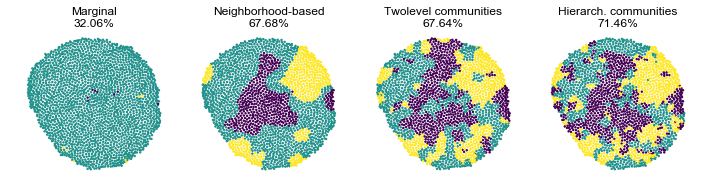

In [25]:
ncols = 4
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*3,3))

plot(axes[0], marginal_labels, 'Marginal')
plot(axes[1], neighborhood_labels, 'Neighborhood-based')
plot(axes[2], twolevel_community_labels, 'Twolevel communities')
plot(axes[3], multilevel_community_labels, 'Hierarch. communities')

In [12]:
from scipy.signal import savgol_filter

In [6]:
from clones.annotation.spatial.correlation import SpatialCorrelation

In [7]:
graph.df['log_clonal_marker'] = np.log(graph.df.clonal_marker)

In [8]:
corr = SpatialCorrelation(graph.df, channel='log_clonal_marker', y_only=False)

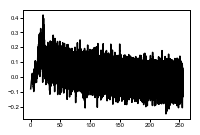

In [27]:
ind = np.argsort(corr.d_ij)

w = 1001
x = savgol_filter(corr.d_ij[ind], w, 3)
y = savgol_filter(corr.C_ij[ind], w, 3)

# plot moving average
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(x, y, '-k')

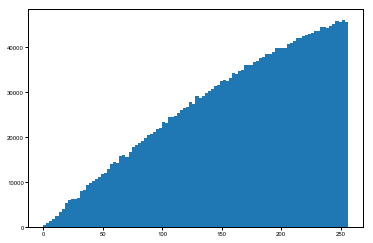

In [12]:
_ = plt.hist(corr.d_ij, bins=100)

In [16]:
np.vstack(list(graph.node_positions.values()))

array([[356., 694.],
       [354., 717.],
       [364., 736.],
       ...,
       [299., 618.],
       [313., 637.],
       [319., 625.]])

In [7]:
from clones.annotation.spatial.infomap import InfoMap

In [28]:

#labels = community_detector(self.nodes, level)

# add labels to dataframe
#index = np.arange(len(self.df))
#self.df['community'] = labels[self.node_map(index)]

In [10]:
community_detector(graph.nodes, level=-1)

array([269, 260, 260, ..., 170, 170, 170])

In [87]:
from copy import deepcopy

def spatial_correlation(graph):

    graph.find_communities()
    community_detector = InfoMap(graph.edge_list, twolevel=False)

    df = deepcopy(graph.df[['community', 'clonal_marker']])
    
    df['zscore'] = (df.clonal_marker - df.clonal_marker.mean())/df.clonal_marker.std()
    
    f = lambda x: sum([sum([x_i * x_j for x_j in x if x_i!=x_j]) for x_i in x])/2
    g = lambda x: len(x)*(len(x)-1)/2
    
    
    phis = []
    for level in range(community_detector.aggregator.max_depth):
        key = '{:d}'.format(level)
        df[key] = community_detector.aggregator(df.community, level=level)
        phi = df.groupby(key)['zscore'].agg(f).sum() / df.groupby(key)['zscore'].agg(g).sum()
        phis.append((level, phi))
    
    return phis

In [88]:
correlation = spatial_correlation(graph)

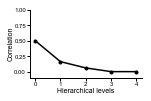

In [89]:
fig, ax = plt.subplots(figsize=(2, 1.25))
ax.plot(*list(zip(*correlation)), '.-k')
ax.set_ylim(-0.1, 1)
ax.set_ylabel('Correlation')
ax.set_xlabel('Hierarchical levels')
_ = ax.spines['top'].set_visible(False)
_ = ax.spines['right'].set_visible(False)

In [70]:

g([1,2,3,4])

6.0

In [53]:
f(x)

35.0

# graph correlation

In [226]:
max_depth = 25
paths = nx.all_pairs_shortest_path_length(graph.G, cutoff=max_depth)

In [227]:
paths = dict(paths)

In [228]:
edge_dict = {i: [] for i in range(max_depth+1)}
for node, neighbors in paths.items():
    for neighbor, distance in neighbors.items():
        edge_dict[distance].append((node, neighbor))

In [235]:
def assess_correlation(edge_list):
    idx = np.array(edge_list)
    flux = ((levels.loc[idx[:, 0]].values - mu) * (levels.loc[idx[:, 1]].values - mu)) / sigma2
    return flux.mean(), flux.std(), flux.size

In [241]:
means, sigmas, sizes = list(zip(*[assess_correlation(e) for e in edge_dict.values()]))

means = np.array(means)
sigmas = np.array(sigmas)
sizes = np.array(sizes)

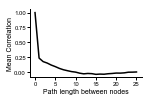

In [245]:
fig, ax = plt.subplots(figsize=(2, 1.25))
ax.fill_between(np.arange(max_depth+1), means-sigmas/sizes, means+sigmas/sizes, alpha=.5)
ax.plot(means, '-k')

ax.set_xlabel('Path length between nodes')
ax.set_ylabel('Mean Correlation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

